# Offline pipeline for data generation

## Import libraries and files

In [1]:
import cv2
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import glob
import json
import sys

In [2]:
%load_ext autoreload
%autoreload 2
sys.path.insert(0, '../../')  # This adds the parent directory to the path

In [28]:
file_path = '../../config.json'

with open(file_path, 'r') as file:
    config = json.load(file)

config_json = json.dumps(config, indent=2)
config_dict = json.loads(config_json)

## Extract frames from video sequences

In [29]:
from src.frames_extractor import FrameExtractor

frame_extractor = FrameExtractor(
    config = config_dict,
    frames_dir = 'frames',
    verbose = False
    )

frame_extractor.extract_frames()

SHOWING VIEW: 060
Showing subject: 014


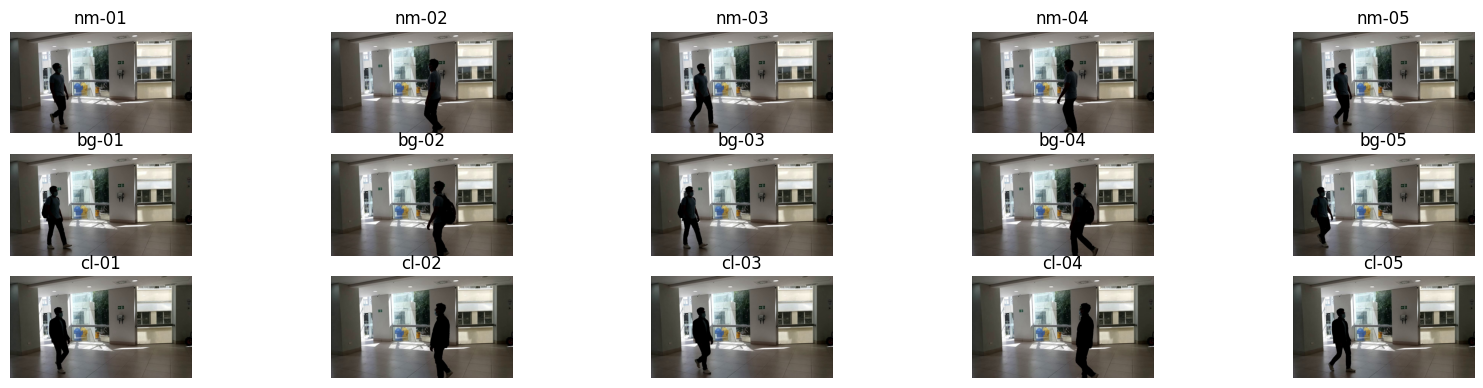

SHOWING VIEW: 075
Showing subject: 009


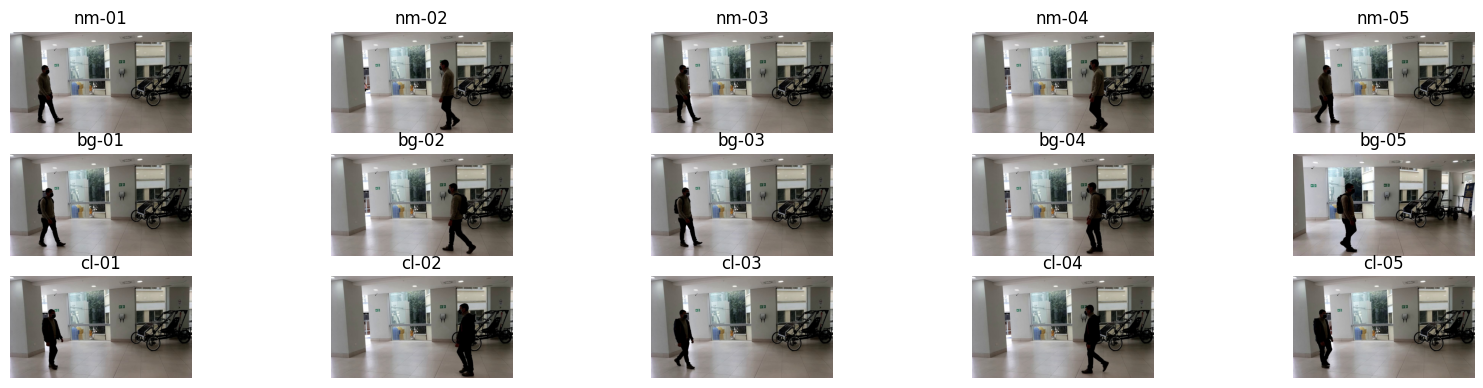

SHOWING VIEW: 090
Showing subject: 012


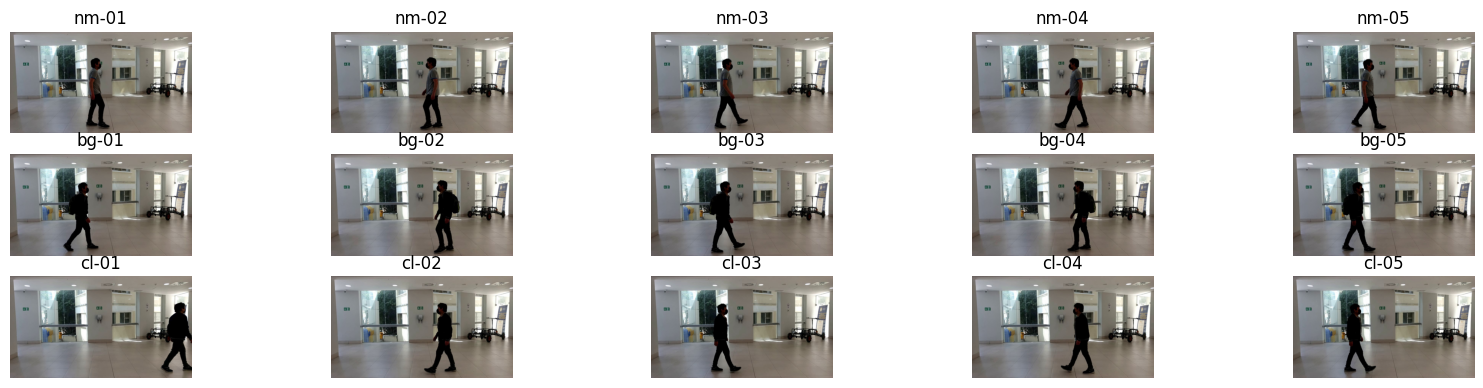

SHOWING VIEW: 105
Showing subject: 000


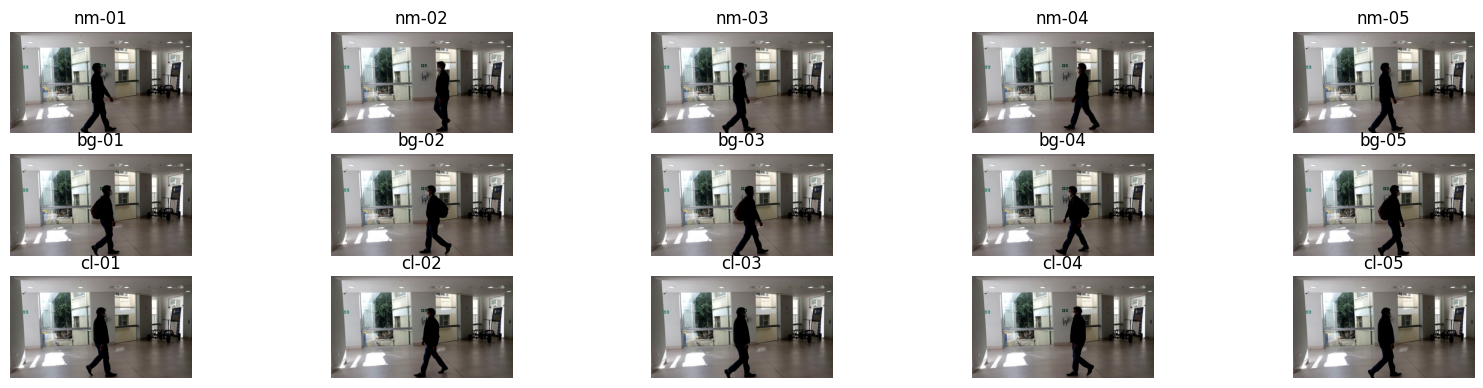

SHOWING VIEW: 120
Showing subject: 014


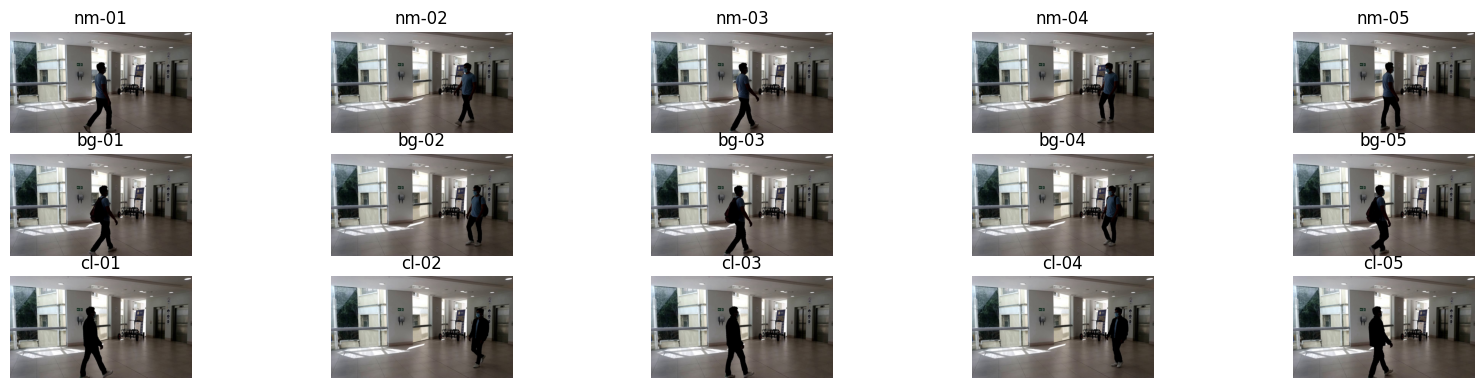

In [38]:
from src.show_images import show_images

show_images(config=config_dict, images_dir=f"{config['dataset_dir']}/{config['dataset_name']}/frames", num_subjects=1)

## Generate test dataset

In [3]:
from src.test_data_generator import TestDataGenerator

test_data_generator = TestDataGenerator(
    config = config_dict,
    test_clips_dir = 'test_clips',
    verbose = False
)

test_data_generator.generate_test_data()

PROCESSING VIEW: 060
Processing subject: 000 view: 060
Processing subject: 001 view: 060
Processing subject: 002 view: 060
Processing subject: 003 view: 060
Processing subject: 004 view: 060
Processing subject: 005 view: 060
Processing subject: 006 view: 060
Processing subject: 007 view: 060
Processing subject: 008 view: 060
Processing subject: 009 view: 060
Processing subject: 010 view: 060
Processing subject: 011 view: 060
Processing subject: 012 view: 060
Processing subject: 013 view: 060
Processing subject: 014 view: 060
Processing subject: 015 view: 060
Processing subject: 016 view: 060
PROCESSING VIEW: 075
Processing subject: 000 view: 075
Processing subject: 001 view: 075
Processing subject: 002 view: 075
Processing subject: 003 view: 075
Processing subject: 004 view: 075
Processing subject: 005 view: 075
Processing subject: 006 view: 075
Processing subject: 007 view: 075
Processing subject: 008 view: 075
Processing subject: 009 view: 075
Processing subject: 010 view: 075
Proces

## Detection: region-of-interest extraction

For this section, the object detection model [mobileNet-ssd](https://docs.openvino.ai/latest/omz_models_model_mobilenet_ssd.html) from OpenVINO distribution was employed. It is worth mentioning that for this stage there was no retraining process, as the pre-trained model was used directly.

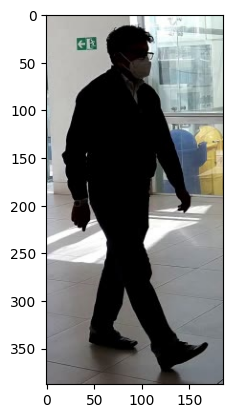

In [44]:
from src.roi_finder import ROIFinder
import matplotlib.pyplot as plt

roi_finder = ROIFinder(model_path="../../models/public/mobilenet-ssd/FP32/mobilenet-ssd.xml", device="CPU")

rgb = cv2.imread('../../Datasets/OakGait16/frames/060/rgb/000/nm/nm-03/0048.jpg')
x, y, w, h = roi_finder.find_roi(rgb)
roi = cv2.cvtColor(rgb[y:h, x:w], cv2.COLOR_BGR2RGB)

plt.imshow(roi)
plt.show()

In [41]:
from src.roi_extractor import ROIExtractor

roi_extractor = ROIExtractor(
        images_dir = '../../Datasets/OakGait16/frames/',
        region_of_interest_dir = '../../Datasets/OakGait16/rois/',
        frs_dir = 'rgb/',
        views = ['060', '075', '090', '105', '120'], 
        subjects = ['000','001','002','003','004','005','007','008','009','010','011','012','013','014','015','016'],
        roi_finder = roi_finder,
        verbose = False,
        walk_types = ['nm', 'bg', 'cl'],
    )

roi_extractor.extract_roi_from_frames()

SHOWING VIEW: 060
Showing subject: 008


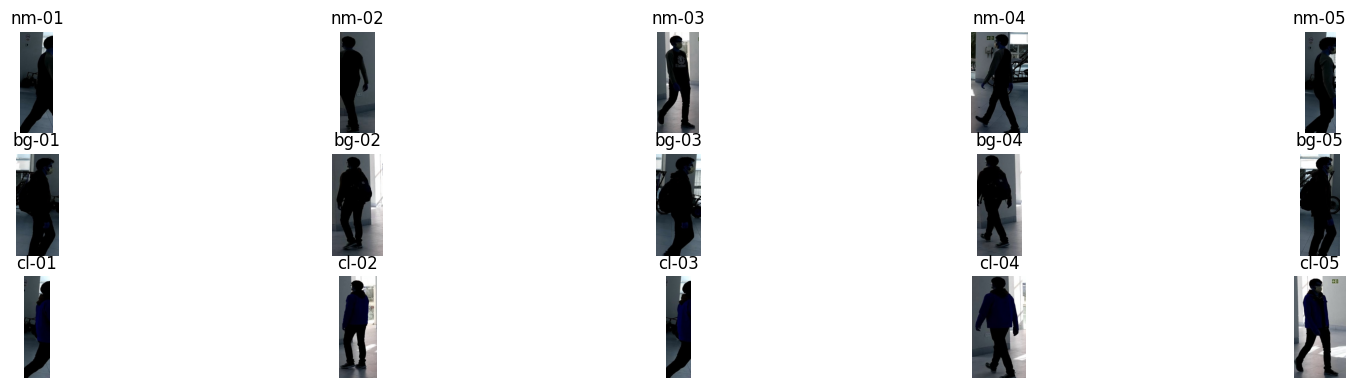

SHOWING VIEW: 075
Showing subject: 016


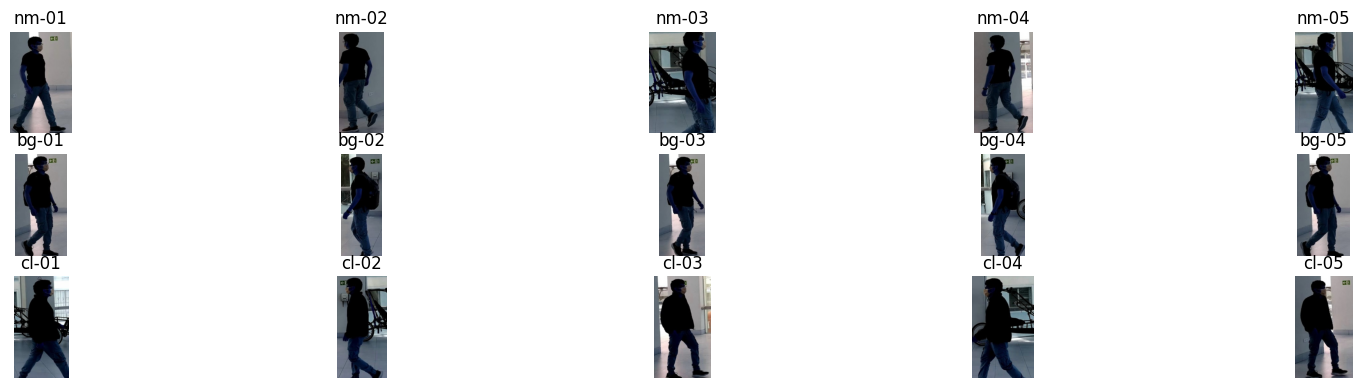

SHOWING VIEW: 090
Showing subject: 009


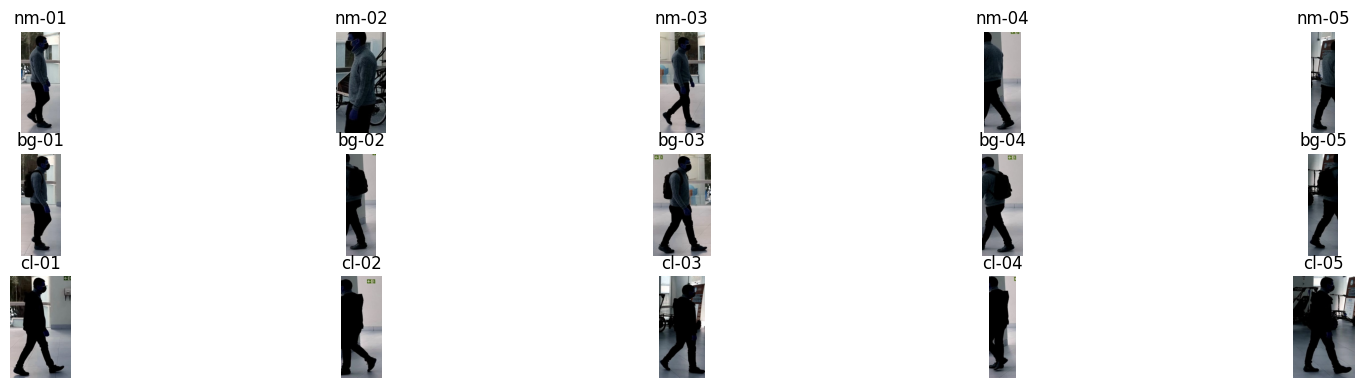

SHOWING VIEW: 105
Showing subject: 015


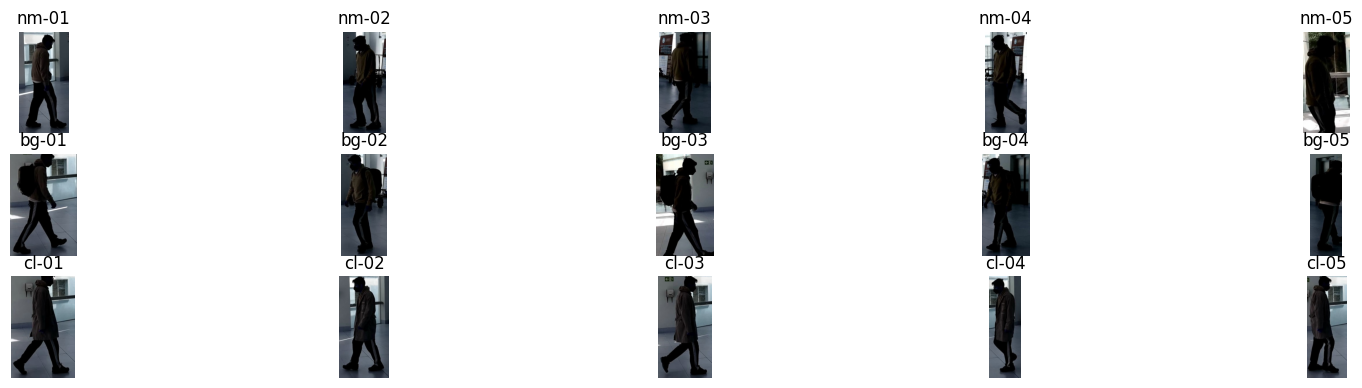

SHOWING VIEW: 120
Showing subject: 004


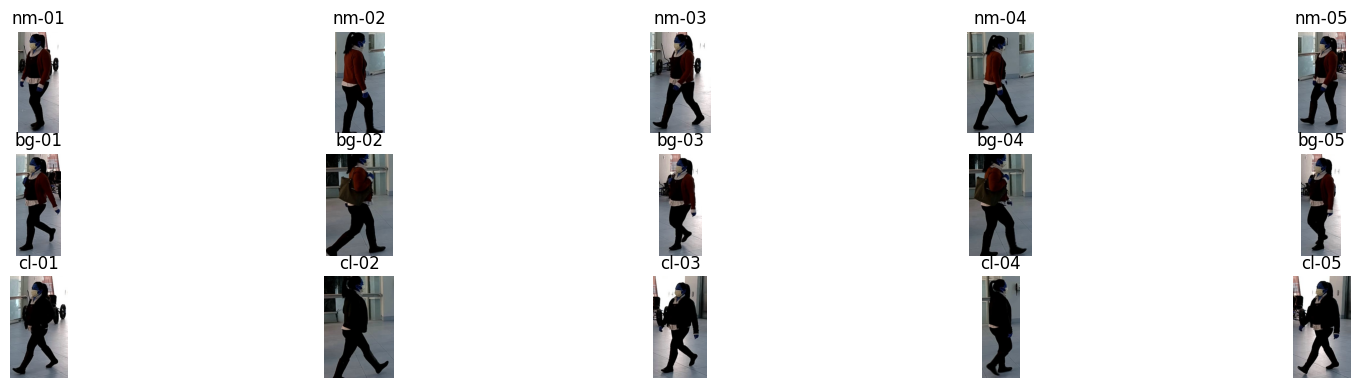

In [10]:
show_images(images_dir='../../Datasets/OakGait16/rois/', views =  ['060', '075', '090', '105', '120'], num_subjects=1)

## Segmentation: semantic segmentation for obtaining binary silhouettes

(384, 149)


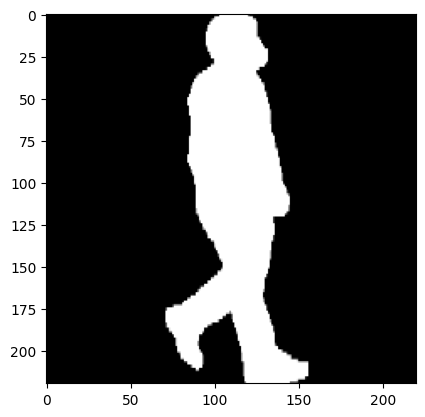

In [57]:
from src.silhouette_segmenter import SilhouetteSegmenter

segmenter = SilhouetteSegmenter(
    model_path="../../models/128x128_acc_0.8786_loss_0.1018_val-acc_0.8875_val-loss_0.0817_0.22M_13-09-22-TF_OAKGait16.xml", 
    device="CPU"
    )

# Test the silhouette segmenter
roi = cv2.imread("../../Datasets/OakGait16/rois/090/000/nm/nm-03/000-nm-03-23.jpg")
roi_height = roi.shape[0]
roi_width = roi.shape[1]
roi = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
sil = cv2.resize(segmenter.sil_segmentation(roi), (roi_width,roi_height)) 
plt.imshow(sil, cmap='gray')
if sil.mean() > 2:
    x, y, w, h = cv2.boundingRect(sil)
    seg_roi = sil[y:y+h,x:x+w]
    print(seg_roi.shape)
    sil_centered = segmenter.sil_centering(sil, 220)
    plt.imshow(sil_centered, cmap='gray')

In [58]:
from src.silhouette_extractor import SilhouetteExtractor

silhouette_extractor = SilhouetteExtractor(
    region_of_interest_dir = '../../Datasets/OakGait16/rois/',
    silhouettes_dir = '../../Datasets/OakGait16/segmented_silhouettes/',
    views = ['060', '075', '090', '105', '120'], 
    segmenter = segmenter,
    walks = ['nm', 'bg', 'cl'],
    verbose = False
    )

silhouette_extractor.extract_silhouettes_from_rois()

SHOWING VIEW: 060
Showing subject: 015


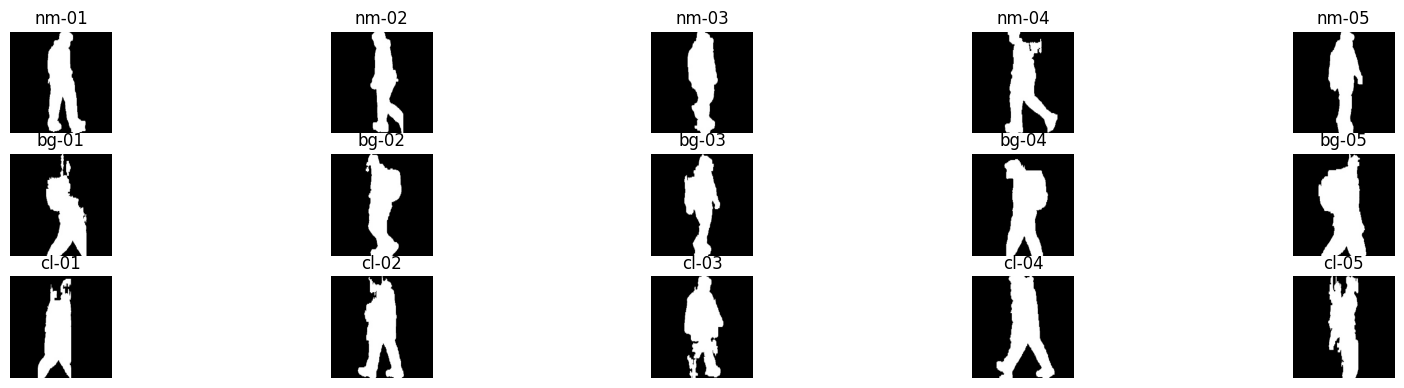

SHOWING VIEW: 075
Showing subject: 016


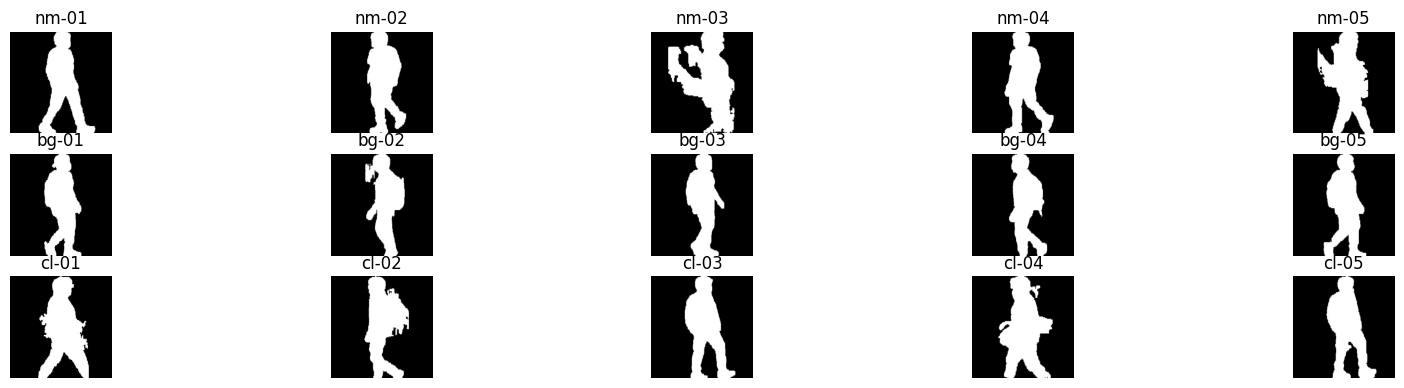

SHOWING VIEW: 090
Showing subject: 016


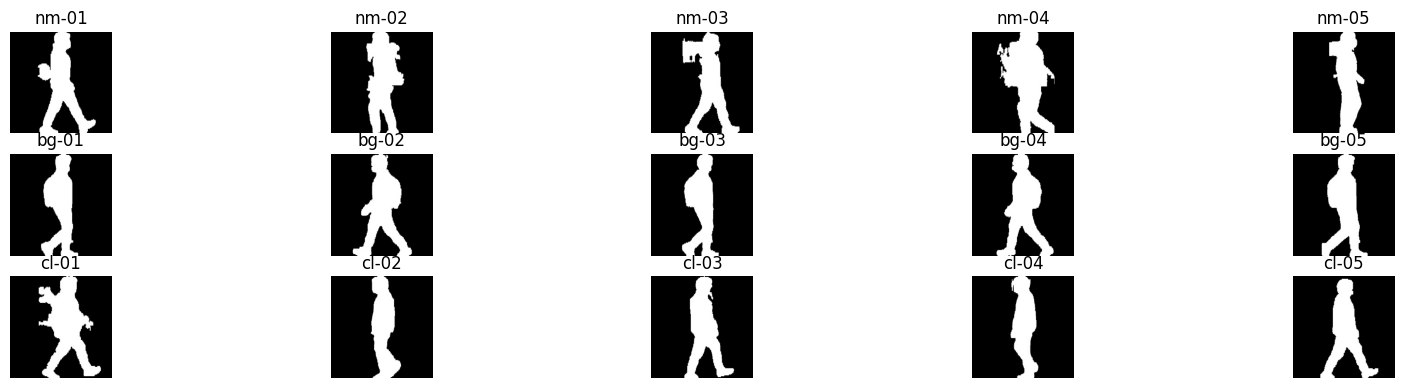

SHOWING VIEW: 105
Showing subject: 000


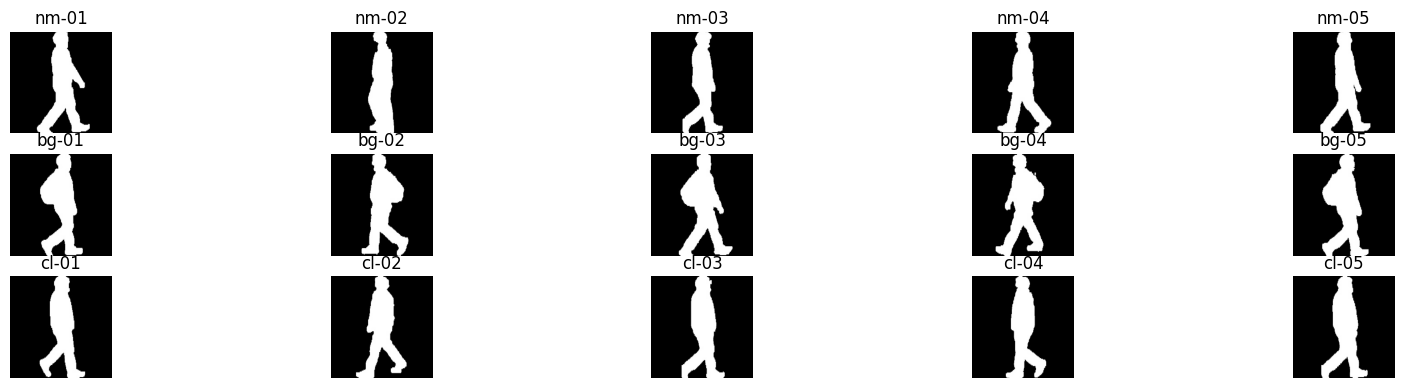

SHOWING VIEW: 120
Showing subject: 014


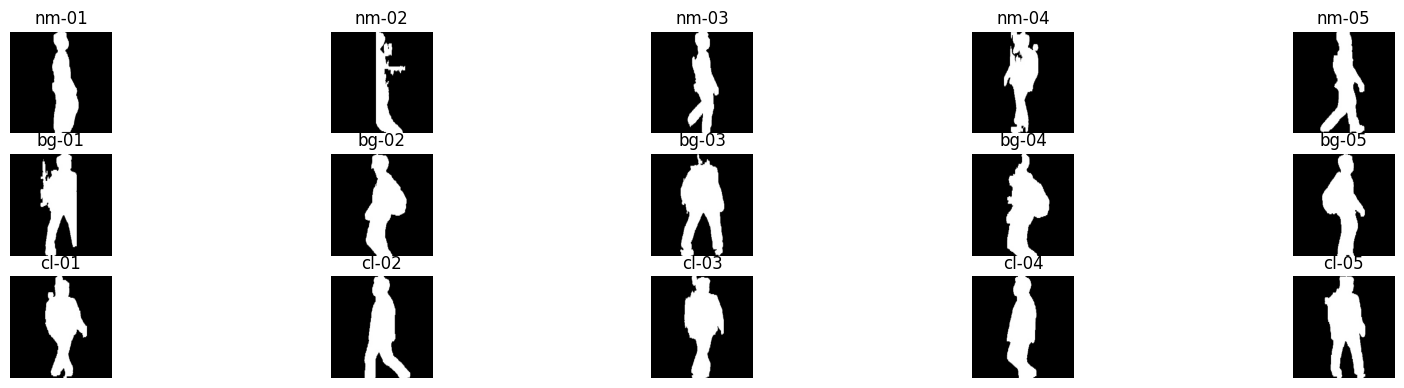

In [11]:
show_images(images_dir='../../Datasets/OakGait16/segmented_silhouettes/', views =  ['060', '075', '090', '105', '120'], num_subjects=1)

## Gait representation: GEI generation

In [18]:
from src.gei_generator import GEIGenerator

gei_generator = GEIGenerator(
    silhouettes_dir = '../../Datasets/OakGait16/segmented_silhouettes/',
    representations_dir = '../../Datasets/OakGait16/gei_representations/',
    views = ['060', '075', '090', '105', '120'],
    walks = ['nm', 'bg', 'cl'],
    n_frames = 35,
    verbose = False
    )

gei_generator.extract_gei_from_silhouettes()

SHOWING VIEW: 060
Showing subject: 008


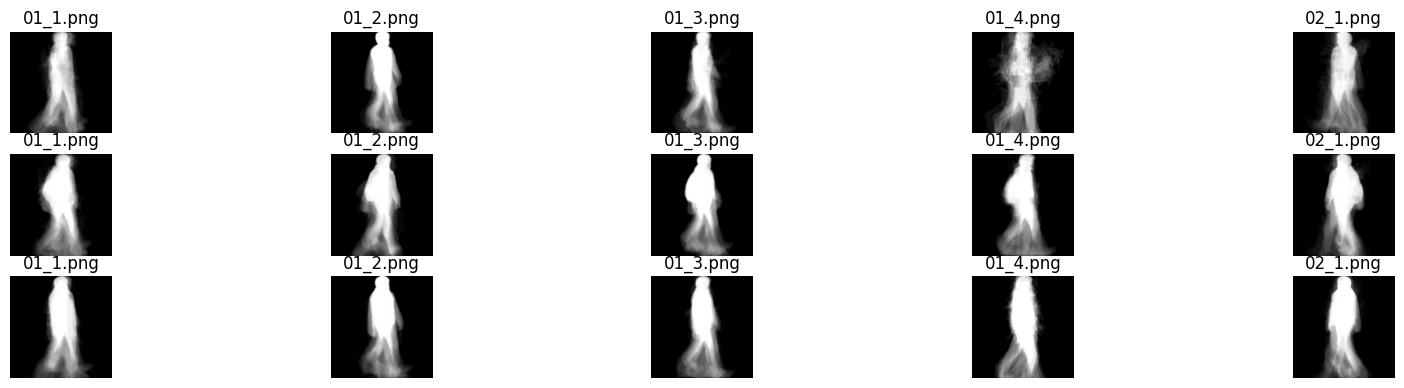

SHOWING VIEW: 075
Showing subject: 008


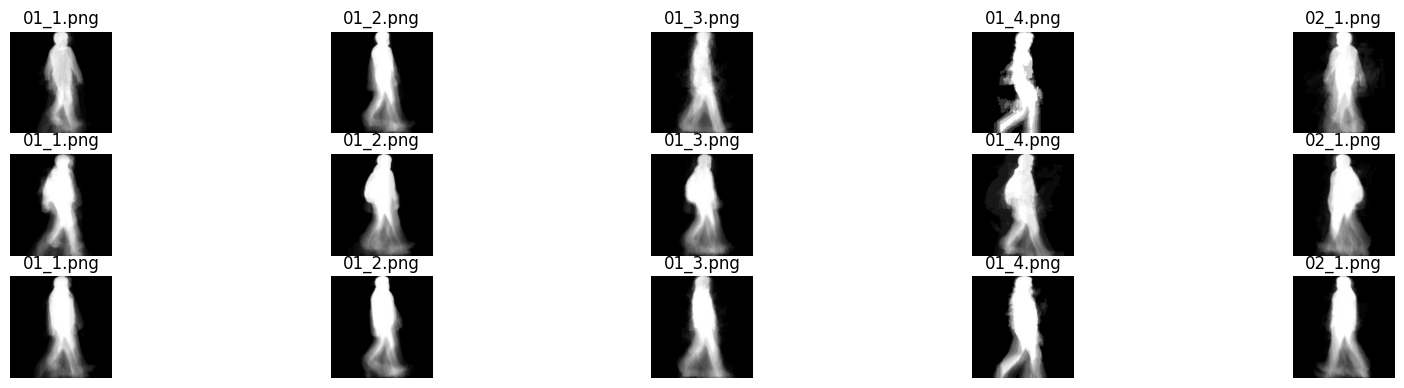

SHOWING VIEW: 090
Showing subject: 003


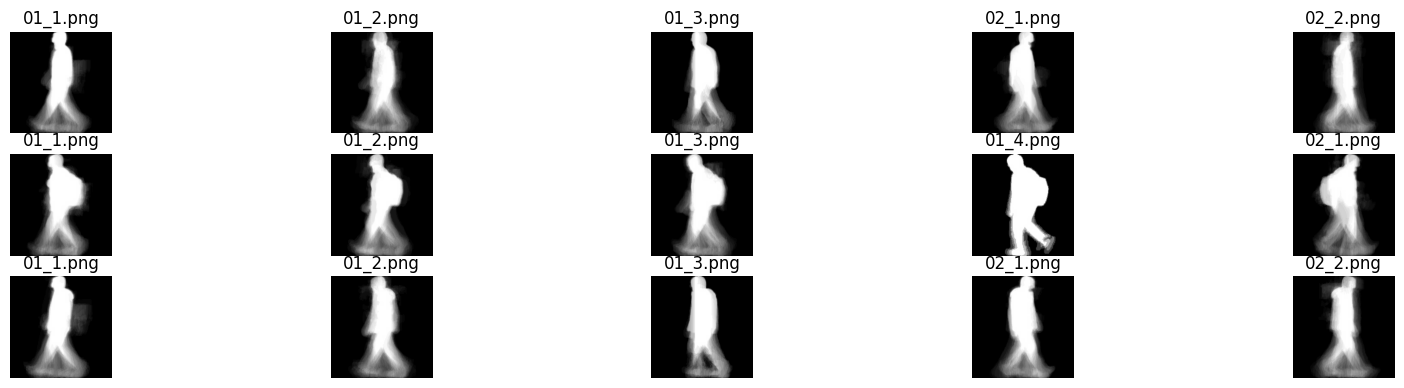

SHOWING VIEW: 105
Showing subject: 010


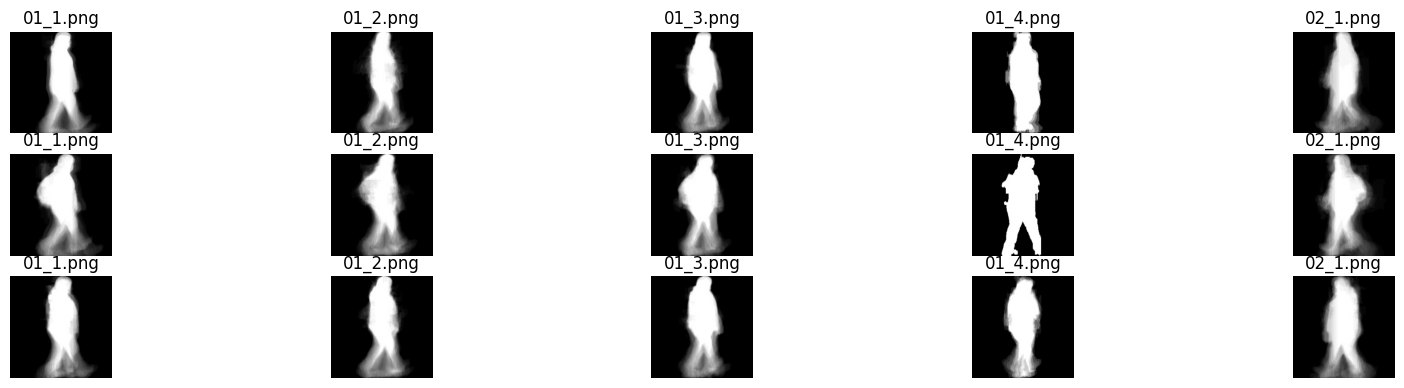

SHOWING VIEW: 120
Showing subject: 004


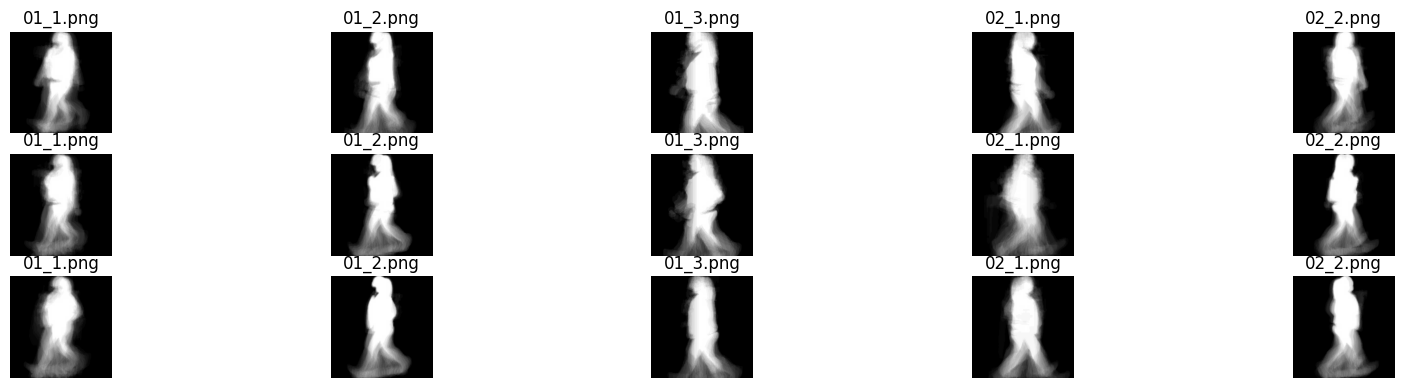

In [19]:
from src.show_representations import show_representations
show_representations('../../Datasets/OakGait16/gei_representations/', ['060', '075', '090', '105', '120'], num_subjects=1)

## Classification dataset generation

In [25]:
from src.dataset_builder import RepresentationsDatasetBuilder

builder = RepresentationsDatasetBuilder(
    representations_dir='../../Datasets/OakGait16/gei_representations', 
    training_path='../../Datasets/OakGait16/representations_training_dataset', 
    views=['060', '075', '090', '105', '120'],
    )
builder.build_datasets()

Processing subject: 000 view: 060 walk:nm
060-nm-03_2.png
060-nm-04_1.png
060-nm-05_2.png
060-nm-04_3.png
060-nm-04_2.png
060-nm-01_3.png
060-nm-05_3.png
060-nm-05_1.png
060-nm-02_4.png
060-nm-03_1.png
060-nm-02_3.png
060-nm-05_4.png
060-nm-01_4.png
060-nm-03_4.png
060-nm-01_2.png
060-nm-02_2.png
060-nm-01_1.png
060-nm-03_3.png
060-nm-02_1.png
Processing subject: 000 view: 060 walk:bg
060-bg-03_2.png
060-bg-04_1.png
060-bg-05_2.png
060-bg-04_3.png
060-bg-04_2.png
060-bg-01_3.png
060-bg-05_3.png
060-bg-05_1.png
060-bg-03_1.png
060-bg-02_3.png
060-bg-05_4.png
060-bg-03_4.png
060-bg-01_2.png
060-bg-02_2.png
060-bg-01_1.png
060-bg-03_3.png
060-bg-02_1.png
Processing subject: 000 view: 060 walk:cl
060-cl-03_2.png
060-cl-04_1.png
060-cl-05_2.png
060-cl-04_3.png
060-cl-04_2.png
060-cl-01_3.png
060-cl-05_3.png
060-cl-05_1.png
060-cl-03_1.png
060-cl-02_3.png
060-cl-05_4.png
060-cl-01_4.png
060-cl-03_4.png
060-cl-01_2.png
060-cl-02_2.png
060-cl-01_1.png
060-cl-03_3.png
060-cl-02_1.png
Processing

In [ ]:
from huggingface_hub import from_pretrained_keras

model = from_pretrained_keras("chrisconchari/appearance-based-gait-recognition-classifier")
